In [1]:
import numpy as np
import time
from warnings import warn
from scipy.optimize import line_search
from tabulate import tabulate
import matplotlib.pyplot as plt

class LineSearchWarning(RuntimeWarning):
    pass

def timer(func):
    def wrapper(*args, **kwargs):
        before_time = time.time()
        result = func(*args, **kwargs)
        after_time = time.time()
        elapsed_time = after_time-before_time
        print(f"Время:{elapsed_time}")
        return result, elapsed_time
    return wrapper

def _check_c1_c2(c1, c2):
    if not (0 < c1 < c2 < 1):
        raise ValueError("'c1' and 'c2' do not satisfy"
                         "'0 < c1 < c2 < 1'.")

def chebyshev(a, b, roots=4):
    roots_list = []
    for i in range(1, roots+1):
        x = (a+b)/2-(b-a)/2*(np.cos((2*i-1)*np.pi/(2*roots))/np.cos(np.pi/(2*roots)))
        roots_list.append(x)       
    return roots_list

def cardano(A, B, C, D, a):
    """
    Решает кубическое уравнение вида 4A(X-a)^3 + 3B(X-a)^2 + 2C(X-a) + D = 0.
    
    Параметры:
    A, B, C, D - коэффициенты уравнения.
    a - смещение переменной X.
    
    Возвращает:
    Список корней уравнения (действительных).
    """
    
    p = (2 * C / (4 * A)) - ((3 * B / (4 * A)) ** 2 / 3)
    q = (2 * (3 * B / (4 * A)) ** 3 / 27) - ((3 * B / (4 * A)) * (2 * C / (4 * A)) / 3) + (D / (4 * A))
    
    delta = (q / 2) ** 2 + (p / 3) ** 3
    if delta > 0:
        # Один действительный корень и два комплексных
        u = np.cbrt(-q / 2 + np.sqrt(delta))
        v = np.cbrt(-q / 2 - np.sqrt(delta))
        y1 = u + v
        roots = [y1 - (3 * B / (4 * A)) / 3 + a]
    
    elif delta == 0:
        # Три действительных корня, причем хотя бы два совпадают
        u = (-q / 2) ** (1/3)
        y1 = 2 * u
        y2 = -u
        roots = [y1 - (3 * B / (4 * A)) / 3 + a, y2 - (3 * B / (4 * A)) / 3 + a]
    
    else:
        # Три различных действительных корня
        r = np.sqrt(-(p / 3) ** 3)
        phi = np.arccos(-q / (2 * r))
        y1 = 2 * np.cbrt(r) * np.cos(phi / 3)
        y2 = 2 * np.cbrt(r) * np.cos((phi + 2 * np.pi) / 3)
        y3 = 2 * np.cbrt(r) * np.cos((phi + 4 * np.pi) / 3)
        roots = [
            y1 - (3 * B / (4 * A)) / 3 + a,
            y2 - (3 * B / (4 * A)) / 3 + a,
            y3 - (3 * B / (4 * A)) / 3 + a
        ]
    
    return roots

def _quadmin(a, fa, fpa, b, fb):
    """
    Находит минимум квадратичного полинома, проходящего через точки
    (a,fa), (b,fb) с производной fpa в точке a.

    """
    with np.errstate(divide='raise', over='raise', invalid='raise'):
        try:
            D = fa
            C = fpa
            db = b - a * 1.0
            B = (fb - D - C * db) / (db * db)
            xmin = a - C / (2.0 * B)
        except ArithmeticError:
            return None
    if not np.isfinite(xmin):
        return None
    return xmin

def _cubicmin_derphi(a, fa, fpa, c, fc, fpc):
    """
    Находит минимум кубического полинома, проходящего через точки
    (a,fa), (с,fс) с производной fpa, fpc в точках a и c.
    Если минимум не найден, возвращает None.
    
    """
    with np.errstate(divide='raise', over='raise', invalid='raise'):
        try:
            dc = c - a  
            
            
            matrix = np.array([
                [dc**3, dc**2, dc, 1],  
                [3*dc**2, 2*dc, 1, 0]  
            ])
            
            values = np.array([fc, fpc])
            С = fpa
            D = fa
            A, B = np.linalg.solve(matrix, values)
            
            radical = B * B - 3 * A * C
            xmin = a + (-B + np.sqrt(radical)) / (3 * A)
            
        except (ArithmeticError, np.linalg.LinAlgError):
            return None
    
    if not np.isfinite(xmin):
        return None
    
    return xmin

def _cubicmin(a, fa, fpa, b, fb, c, fc):
    """
    Находит минимум кубического полинома, проходящего через точки
    (a,fa),(b,fb) и (с,fс) с производной fpa в точке a.
    Если минимум не найден, возвращает None.

    """

    with np.errstate(divide='raise', over='raise', invalid='raise'):
        try:
            C = fpa
            db = b - a
            dc = c - a
            denom = (db * dc) ** 2 * (db - dc)
            d1 = np.empty((2, 2))
            d1[0, 0] = dc ** 2
            d1[0, 1] = -db ** 2
            d1[1, 0] = -dc ** 3
            d1[1, 1] = db ** 3
            [A, B] = np.dot(d1, np.asarray([fb - fa - C * db,
                                            fc - fa - C * dc]).flatten())
            A /= denom
            B /= denom
            radical = B * B - 3 * A * C
            xmin = a + (-B + np.sqrt(radical)) / (3 * A)
        except ArithmeticError:
            return None
    if not np.isfinite(xmin):
        return None
    return xmin

In [2]:
def _quarticmin_1(a, fa, fpa, b, fb, d, fd, fpd):
    """
    Находит минимум полинома 4 степени, проходящего через точки
    (a,fa),(b,fb) и (d,fd) с производной fpa, fpd в точках a и d.
    Если минимум не найден, возвращает None.

    """
    with np.errstate(divide='raise', over='raise', invalid='raise'):
        try:
            db = b - a
            dd = d - a

            matrix = np.array([
                [db**4, db**3, db**2],
                [dd**4, dd**3, dd**2],
                [4*dd**3, 3*dd**2, 2*dd]
            ])

            values = np.array([
                fb - fa - fpa * db,
                fd - fa - fpa * dd,
                fpd - fpa
            ])

            denom = (
                db**4 * (dd**3 * 2*dd - dd**2 * 3*dd**2)
                - db**3 * (dd**4 * 2*dd - dd**2 * 4*dd**3)
                + db**2 * (dd**4 * 3*dd**2 - dd**3 * 4*dd**3)
            )

            if denom == 0:
                raise ValueError("Определитель = 0, матрица не обращается")

            adjoint_matrix = np.array([
                [
                    dd**3 * 2*dd - dd**2 * 3*dd**2,
                    -(db**3 * 2*dd - db**2 * 3*dd**2),
                    db**3 * dd**2 - db**2 * dd**3
                ],
                [
                    -(dd**4 * 2*dd - dd**2 * 4*dd**3),
                    db**4 * 2*dd - db**2 * 4*dd**3,
                    -(db**4 * dd**2 - db**2 * dd**4)
                ],
                [
                    dd**4 * 3*dd**2 - dd**3 * 4*dd**3,
                    -(db**4 * 3*dd**2 - db**3 * 4*dd**3),
                    db**4 * dd**3 - db**3 * dd**4
                ]
            ])

            [A, B, C] = np.dot(adjoint_matrix, values)
            A /= denom
            B /= denom
            C /= denom
            D = fpa
            E = fa
            if min(A, B, C, D) < 10e-6:
                roots = np.roots([4*A, 3*B, 2*C, D])
                roots += a
                roots = [root.real for root in roots if root.imag == 0]
            else:
                roots = cardano(A, B, C, D, a)
            valid_roots = [root for root in roots if a < root < d or d < root < a]

            if not valid_roots:
                return None

            def quartic(x):
                return A * (x - a)**4 + B * (x - a)**3 + C * (x - a)**2 + D * (x - a) + E

            x_min = min(valid_roots, key=quartic)

        except ArithmeticError:
            return None
    return x_min

In [3]:
def _quarticmin(a, fa, fpa, b, fb, c, fc, d, fd):

    """
    Находит минимум полинома 4 степени, проходящего через точки
    (a,fa),(b,fb),(c, fc) и (d,fd) с производной fpa в точке a.
    Если минимум не найден, возвращает None.
    """
    with np.errstate(divide='raise', over='raise', invalid='raise'):
        try:
            D = fpa
            db = b - a
            dc = c - a
            dd = d - a
            
            matrix = np.array([
                [db**4, db**3, db**2],
                [dc**4, dc**3, dc**2],
                [dd**4, dd**3, dd**2]
            ])

            values = np.array([
                fb - fa - D * db,
                fc - fa - D * dc,
                fd - fa - D * dd
            ])
            denom = (
                db**4 * (dc**3 * dd**2 - dc**2 * dd**3)
                - db**3 * (dc**4 * dd**2 - dc**2 * dd**4)
                + db**2 * (dc**4 * dd**3 - dc**3 * dd**4)
            )

            if denom == 0:
                raise ValueError("Определитель = 0, матрица не обращается")
            
            adjoint_matrix = np.array([
                [
                    dc**3 * dd**2 - dc**2 * dd**3,
                    -(db**3 * dd**2 - db**2 * dd**3),
                    db**3 * dc**2 - db**2 * dc**3
                ],
                [
                    -(dc**4 * dd**2 - dc**2 * dd**4),
                    db**4 * dd**2 - db**2 * dd**4,
                    -(db**4 * dc**2 - db**2 * dc**4)
                ],
                [
                    dc**4 * dd**3 - dc**3 * dd**4,
                    -(db**4 * dd**3 - db**3 * dd**4),
                    db**4 * dc**3 - db**3 * dc**4
                ]
            ])


            [A, B, C] = np.dot(adjoint_matrix, values)

            A /= denom
            B /= denom
            C /= denom
            D = fpa
            E = fa

            if min(A, B, C, D) < 10e-6:
                roots = np.roots([4*A, 3*B, 2*C, D])
                roots += a
                roots = [root.real for root in roots if root.imag == 0]
            else:
                roots = cardano(A, B, C, D, a)
            valid_roots = [root for root in roots if a < root < d or d < root < a]

            if not valid_roots:
                return None  

            def quartic(x):
                return A * (x - a)**4 + B * (x - a)**3 + C * (x - a)**2 + D * (x - a) + E

            x_min = min(valid_roots, key=quartic)
        except ArithmeticError:
            return None
    return x_min

In [4]:
def _zoom(a_lo, a_hi, phi_lo, phi_hi, derphi_lo,
          phi, derphi, phi0, derphi0, c1, c2, method):
    """
    Zoom метод для поиска шага, удовлетворяющим строгим условиям Вульфа

    Часть алгоритма в `scalar_search_wolfe2`.

    """
    maxiter = 10
    i = 0
    # Параметры delta1 и delta2 контролируют, насколько близко результаты
    # интерполяции могут находиться к границам интервала [a_lo, a_hi].
    delta1 = 0.2  
    delta2 = 0.1  
    phi_rec = phi0
    a_rec = 0
    derphi_hi = None
    while True:
        #Интерполяция, чтобы найти пробную длину шага между a_lo и a_hi.
        dalpha = a_hi - a_lo
        if dalpha < 0:
            a, b = a_hi, a_lo
        else:
            a, b = a_lo, a_hi
      
        qchk = delta2 * dalpha
        cchk = delta1 * dalpha

                    
        #Используется интерполяция 4 порядка, с использованием узлов Чебышева и равноотдаленных узлов, а затем, если результат находится на расстоянии менее delta * dalpha
        #или выходит за пределы интервала, ограниченного a_lo или a_hi,
        #используется метод бисекции.
        
        if method =="chebyshev_roots":
            if (i > 0):
                a_j = _quarticmin(a_lo, phi_lo, derphi_lo, a_rec_1, phi_rec_1, 
                                  a_rec_2, phi_rec_2, a_hi, phi_hi)
            if (i == 0):
                a_rec_1 = chebyshev(a, b)[1]
                phi_rec_1 = phi(a_rec_1)
                a_rec_2 = chebyshev(a, b)[2]
                phi_rec_2 = phi(a_rec_2)
                a_j = _quarticmin(a_lo, phi_lo, derphi_lo, a_rec_1, phi_rec_1, 
                                  a_rec_2, phi_rec_2, a_hi, phi_hi)
            if (a_j is None) or (a_j > b-qchk) or (a_j < a+qchk):
                a_j = a_lo + 0.5*dalpha
                
        if method == "equally_spaced_points":
            if (i > 0):
                a_j = _quarticmin(a_lo, phi_lo, derphi_lo, a_rec_1, phi_rec_1, 
                                  a_rec_2, phi_rec_2, a_hi, phi_hi)
            if (i == 0):
                a_rec_1 = a + (b- a)/3 
                phi_rec_1 = phi(a_rec_1)
                a_rec_2 = a + 2*(b-a)/3
                phi_rec_2 = phi(a_rec_2)

                a_j = _quarticmin(a_lo, phi_lo, derphi_lo, a_rec_1, phi_rec_1, 
                                  a_rec_2, phi_rec_2, a_hi, phi_hi)
            if (a_j is None) or (a_j > b-qchk) or (a_j < a+qchk):
                a_j = a_lo + 0.5*dalpha
                    

        # Используется интерполяция 4 порядка, построенная с помощью точки, 
        # найденной с помощью квадратичной интерполяции и наклонов в крайних точках
        #а затем, если результат находится на расстоянии менее delta * dalpha
        #или выходит за пределы интервала, ограниченного a_lo или a_hi,
        #используется метод бисекции.
        
        if method == "inter_4_with_2":
            if (i > 0):
                a_j = _quarticmin_1(a_lo, phi_lo, derphi_lo, a_rec, phi_rec, 
                                a_hi, phi_hi,derphi_hi)
                
            if (i == 0):
                a_j = _quadmin(a_lo, phi_lo, derphi_lo, a_hi, phi_hi)
            if (a_j is None) or (a_j > b-qchk) or (a_j < a+qchk):
                a_j = a_lo + 0.5*dalpha

        phi_aj = phi(a_j)
        if (phi_aj > phi0 + c1*a_j*derphi0) or (phi_aj >= phi_lo):
            if method =="chebyshev_roots" or method == "equally_spaced_points":
                a_rec_2 = a_rec_1
                phi_rec_2 = phi_rec_1
                phi_rec_1 = phi_hi
                a_rec_1 = a_hi
            phi_rec = phi_hi
            a_rec = a_hi
            a_hi = a_j
            phi_hi = phi_aj
            if method == "inter_3_with_derphi" or method == "inter_4_with_2" or method == "check_slope1" or method == "check_slope2":
                derphi_hi = derphi(a_hi)

        else:
            derphi_aj = derphi(a_j)
            if abs(derphi_aj) <= -c2*derphi0:
                a_star = a_j
                val_star = phi_aj
                valprime_star = derphi_aj
                break
            if derphi_aj*(a_hi - a_lo) >= 0:
                phi_rec = phi_hi
                a_rec = a_hi
                if method =="chebyshev_roots" or method == "equally_spaced_points":
                    a_rec_2 = a_rec_1
                    phi_rec_2 = phi_rec_1
                    phi_rec_1 = phi_hi
                    a_rec_1 = a_hi
                a_hi = a_lo
                phi_hi = phi_lo
                derphi_hi = derphi_lo
            else:
                phi_rec = phi_lo
                a_rec = a_lo
                if method =="chebyshev_roots" or method == "equally_spaced_points":
                    a_rec_2 = a_rec_1
                    phi_rec_2 = phi_rec_1
                    a_rec_1 = a_lo
                    phi_rec_1 = phi_lo
                if method == "inter_3_with_derphi" or method == "inter_4_with_2" or method == "check_slope1" or method == "check_slope2":
                    if derphi_hi is None:
                        derphi_hi = derphi(a_hi)

            a_lo = a_j
            phi_lo = phi_aj
            derphi_lo = derphi_aj
        i += 1
        if (i > maxiter):
            a_star = None
            val_star = None
            valprime_star = None
            break
    return a_star, val_star, valprime_star

In [5]:
def scalar_search_wolfe2(phi, derphi, method, phi0=None,
                         old_phi0=None, derphi0=None,
                         c1=1e-4, c2=0.9, amax=None,
                          maxiter=100):
    """
    Находит alphа, удовлетворяющее сильным условиям Вульфа.

    предполагается, что alpha > 0 - направление спуска.
    Parameters
    ----------
    phi : callable phi(alpha)
        Objective scalar function.
    derphi : callable phi'(alpha)
        Objective function derivative. Returns a scalar.
    method : string
        Method
    phi0 : float, optional
        Value of phi at 0.
    old_phi0 : float, optional
        Value of phi at previous point.
    derphi0 : float, optional
        Value of derphi at 0
    c1 : float, optional
        Parameter for Armijo condition rule.
    c2 : float, optional
        Parameter for curvature condition rule.
    amax : float, optional
        Maximum step size.
    maxiter : int, optional
        Maximum number of iterations to perform.

    Returns
    -------
    alpha_star : float or None
        Best alpha, or None if the line search algorithm did not converge.
    phi_star : float
        phi at alpha_star.
    phi0 : float
        phi at 0.
    derphi_star : float or None
        derphi at alpha_star, or None if the line search algorithm
        did not converge.

    """
    _check_c1_c2(c1, c2)

    if phi0 is None:
        phi0 = phi(0.)

    if derphi0 is None:
        derphi0 = derphi(0.)

    alpha0 = 0
    if old_phi0 is not None and derphi0 != 0:
        alpha1 = min(1.0, 1.01*2*(phi0 - old_phi0)/derphi0)
    else:
        alpha1 = 1.0

    if alpha1 < 0:
        alpha1 = 1.0

    if amax is not None:
        alpha1 = min(alpha1, amax)

    phi_a1 = phi(alpha1)

    phi_a0 = phi0
    derphi_a0 = derphi0


    for i in range(maxiter):
        if alpha1 == 0 or (amax is not None and alpha0 > amax):
            alpha_star = None
            phi_star = phi0
            phi0 = old_phi0
            derphi_star = None

            if alpha1 == 0:
                msg = 'Rounding errors prevent the line search from converging'
            else:
                msg = "The line search algorithm could not find a solution " + \
                      f"less than or equal to amax: {amax}"

            warn(msg, LineSearchWarning, stacklevel=2)
            break
        not_first_iteration = i > 0
        if (phi_a1 > phi0 + c1 * alpha1 * derphi0) or \
           ((phi_a1 >= phi_a0) and not_first_iteration):
            alpha_star, phi_star, derphi_star = \
                        _zoom(alpha0, alpha1, phi_a0,
                              phi_a1, derphi_a0, phi, derphi,
                              phi0, derphi0, c1, c2, method)
            break

        derphi_a1 = derphi(alpha1)
        if (abs(derphi_a1) <= -c2*derphi0):
            alpha_star = alpha1
            phi_star = phi_a1
            derphi_star = derphi_a1
            break

        if (derphi_a1 >= 0):
            alpha_star, phi_star, derphi_star = \
                        _zoom(alpha1, alpha0, phi_a1,
                              phi_a0, derphi_a1, phi, derphi,
                              phi0, derphi0, c1, c2, method)
            break

        alpha2 = 2 * alpha1  
        if amax is not None:
            alpha2 = min(alpha2, amax)
        alpha0 = alpha1
        alpha1 = alpha2
        phi_a0 = phi_a1
        phi_a1 = phi(alpha1)
        derphi_a0 = derphi_a1

    else:
        alpha_star = alpha1
        phi_star = phi_a1
        derphi_star = None
        warn('The line search algorithm did not converge',
             LineSearchWarning, stacklevel=2)
    return alpha_star, phi_star, phi0, derphi_star

In [6]:
def line_search_wolfe2(f, myfprime, xk, pk, method, gfk=None, old_fval=None,
                       old_old_fval=None, args=(), c1=1e-4, c2=0.9, amax=None,
                         maxiter=10):
    """
    Находит alpha, удовлетворяющее сильным условиям Вульфа.

    Parameters
    ----------
    f : callable f(x,*args)
        Objective function.
    myfprime : callable f'(x,*args)
        Objective function gradient.
    xk : ndarray
        Starting point.
    pk : ndarray
        Search direction. The search direction must be a descent direction
        for the algorithm to converge.
    method : string
        Method
    gfk : ndarray, optional
        Gradient value for x=xk (xk being the current parameter
        estimate). Will be recomputed if omitted.
    old_fval : float, optional
        Function value for x=xk. Will be recomputed if omitted.
    old_old_fval : float, optional
        Function value for the point preceding x=xk.
    args : tuple, optional
        Additional arguments passed to objective function.
    c1 : float, optional
        Parameter for Armijo condition rule.
    c2 : float, optional
        Parameter for curvature condition rule.
    amax : float, optional
        Maximum step size
    maxiter : int, optional
        Maximum number of iterations to perform.

    Returns
    -------
    alpha : float or None
        Alpha for which ``x_new = x0 + alpha * pk``,
        or None if the line search algorithm did not converge.
    fc : int
        Number of function evaluations made.
    gc : int
        Number of gradient evaluations made.
    new_fval : float or None
        New function value ``f(x_new)=f(x0+alpha*pk)``,
        or None if the line search algorithm did not converge.
    old_fval : float
        Old function value ``f(x0)``.
    new_slope : float or None
        The local slope along the search direction at the
        new value ``<myfprime(x_new), pk>``,
        or None if the line search algorithm did not converge.
    """
    fc = [0]
    gc = [0]
    gval = [None]
    gval_alpha = [None]

    def phi(alpha):
        fc[0] += 1
        return f(xk + alpha * pk, *args)

    fprime = myfprime

    def derphi(alpha):
        gc[0] += 1
        gval[0] = fprime(xk + alpha * pk, *args)  
        gval_alpha[0] = alpha
        return np.dot(gval[0], pk)

    if gfk is None:
        gfk = fprime(xk, *args)
    derphi0 = np.dot(gfk, pk)


    alpha_star, phi_star, old_fval, derphi_star = scalar_search_wolfe2(
            phi, derphi, method, old_fval, old_old_fval, derphi0, c1, c2, amax,
            maxiter=maxiter)

    if derphi_star is None:
        warn('The line search algorithm did not converge',
             LineSearchWarning, stacklevel=2)
    else:
        derphi_star = gval[0]
    return alpha_star, fc[0], gc[0], phi_star, old_fval, derphi_star


In [20]:
@timer
def gradient_descent_four(f, grad_f, start_point,ideal_solution, method, epsilon=1e-6, max_iterations=100):
    """
    Градиентный спуск с правилом Вульфа.

    Parameters
    ----------
    f : callable f(x,*args)
        Objective function.
    grad_f : callable f'(x,*args)
        Objective function gradient.
    start_point : ndarray
        Starting point.
    epsilon: int
        Accuracy
    maxiter : int, optional
        Maximum number of iterations to perform.
        
    Returns
    -------
    alpha_1 : float or None
        Alpha for which ``x_new = x0 + alpha * pk`` at 1 iteration,
        or None if the line search algorithm did not converge.
    x_k : float or None
        x_k for which ``x_k = x0 + alpha * pk``,
        or None if the line search algorithm did not converge.
    fun_count : int
        Number of function evaluations made.
    grad_count : int
        Number of gradient evaluations made.
    iteration : int
       number of iterations
    """
    x_k = start_point
    iteration = 0
    fun_count = 0
    grad_count = 0
    tolerance = 0.01 

    while iteration < max_iterations:
        gradient = grad_f(x_k)
        
        if np.linalg.norm(gradient) <= epsilon:
            print(f"Сходимость достигнута за {iteration} итераций.")
            return alpha_1, x_k, fun_count, grad_count,iteration
        
        if ideal_solution is not None and np.linalg.norm(x_k - ideal_solution) <= tolerance:
            print(f"Достигнута точность по отклонению от идеального решения за {iteration} итераций.")
            return alpha_1, x_k, fun_count, grad_count, iteration
        d_k = -gradient
        alpha_k, fc, gc, new_fval, old_fval, new_slope  = line_search_wolfe2(f, grad_f, x_k, d_k, method, c2=0.1)
        x_k = x_k + alpha_k * d_k
        print(f(x_k))
        if iteration == 0:
            alpha_1 = alpha_k
            print(f"Альфа при 1 итерации:{alpha_k}")
            print(f"Точка при 1 итерации:{x_k}")
        fun_count += fc
        grad_count += gc
        iteration += 1
    
    print(f"Достигнуто максимальное число итераций ({max_iterations}).")
    return alpha_1, x_k, fun_count, grad_count,iteration

In [8]:
@timer
def gradient_descent_three(f, grad_f, start_point,ideal_solution, epsilon=1e-6, max_iterations=100):
    """
    Градиентный спуск с правилом Вульфа.

    Parameters
    ----------
    f : callable f(x,*args)
        Objective function.
    grad_f : callable f'(x,*args)
        Objective function gradient.
    start_point : ndarray
        Starting point.
    epsilon: int
        Accuracy
    maxiter : int, optional
        Maximum number of iterations to perform.
        
    Returns
    -------
    alpha_1 : float or None
        Alpha for which ``x_new = x0 + alpha * pk`` at 1 iteration,
        or None if the line search algorithm did not converge.
    x_k : float or None
        x_k for which ``x_k = x0 + alpha * pk``,
        or None if the line search algorithm did not converge.
    fun_count : int
        Number of function evaluations made.
    grad_count : int
        Number of gradient evaluations made.
    iteration : int
       number of iterations
    """
    
    x_k = start_point
    trajectory = [x_k]
    iteration = 0
    fun_count = 0
    grad_count = 0
    tolerance = 0.01 
    while iteration < max_iterations:
        gradient = grad_f(x_k)
        
        if np.linalg.norm(gradient) <= epsilon:
            print(f"Сходимость достигнута за {iteration} итераций.")
            return alpha_1, x_k, fun_count, grad_count, iteration, trajectory
        
        if ideal_solution is not None and np.linalg.norm(x_k - ideal_solution) <= tolerance:
            print(f"Достигнута точность по отклонению от идеального решения за {iteration} итераций.")
            return alpha_1, x_k, fun_count, grad_count, iteration
        
        d_k = -gradient
        alpha_k, fc, gc, new_fval, old_fval, new_slope =line_search(f, grad_f, x_k, d_k, gfk=None, old_fval=None, old_old_fval=None, args=(), c1=0.0001, c2=0.1, amax=None, extra_condition=None, maxiter=10)
        x_k = x_k + alpha_k * d_k
        if iteration == 0:
            alpha_1 = alpha_k
            print(f"Альфа при 1 итерации:{alpha_k}")
            print(f"Точка при 1 итерации:{x_k}")
        trajectory.append(x_k.copy())
        fun_count += fc
        grad_count += gc
        iteration += 1
    
    print(f"Достигнуто максимальное число итераций ({max_iterations}).")
    return alpha_1, x_k, fun_count, grad_count, iteration, trajectory

# Функция Розенброка

Альфа при 1 итерации:0.002162299849258241
Точка при 1 итерации:[-1.57135618  2.41249054]
Достигнуто максимальное число итераций (1000).
Время:0.295623779296875
Альфа при 1 итерации:0.0021479831637485703
Точка при 1 итерации:[-1.54837217  2.4064489 ]
Достигнута точность по отклонению от идеального решения за 802 итераций.
Время:0.7199563980102539
Альфа при 1 итерации:0.0021479831637485703
Точка при 1 итерации:[-1.54837217  2.4064489 ]
Достигнута точность по отклонению от идеального решения за 802 итераций.
Время:0.7412631511688232
Альфа при 1 итерации:0.0021479831637485703
Точка при 1 итерации:[-1.54837217  2.4064489 ]
Достигнута точность по отклонению от идеального решения за 802 итераций.
Время:0.6094355583190918
+-------------------+----------------+----------------+------------+-------------------------+------------------+---------+
| Метод             |   Кол-во вычиc |   Кол-во вычиc |    Кол-во  | x_min                   |         f(x_min) |   Время |
|                   |       

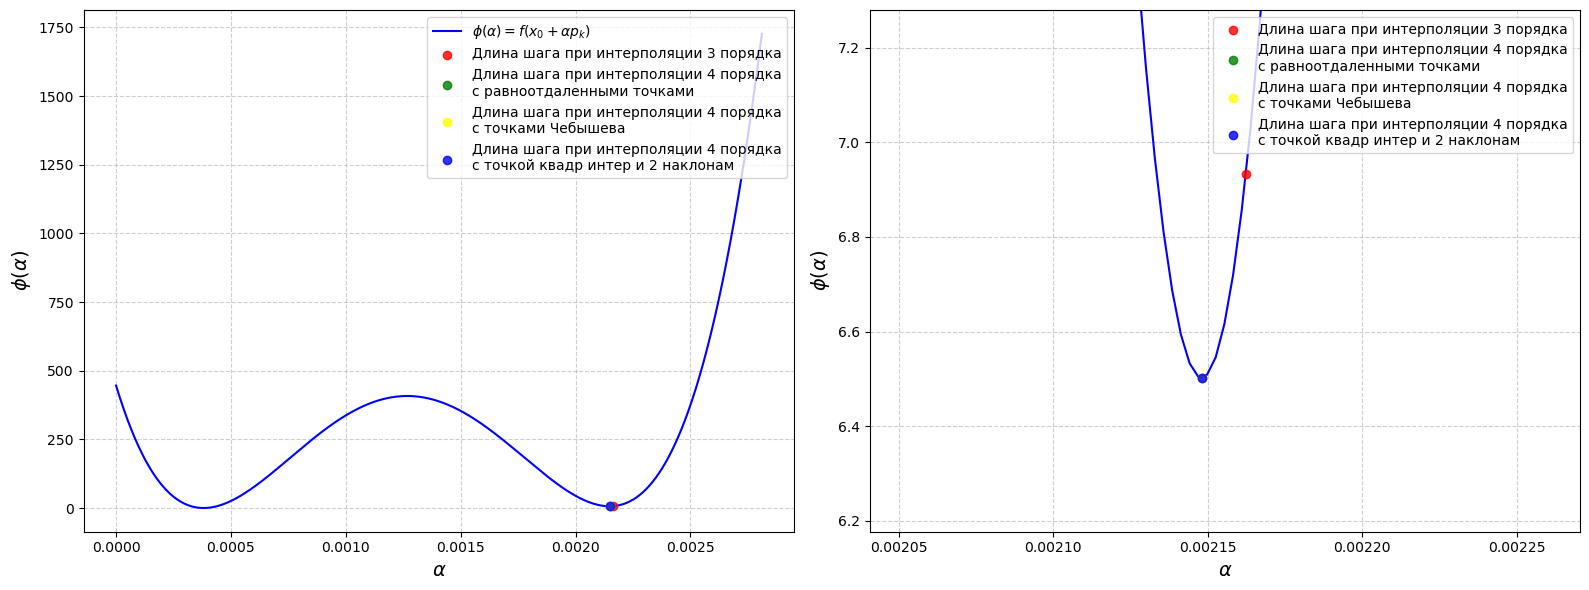

In [9]:

def rosenbrock(x):
    return (1 - x[0])**2 + 100 * (x[1] - x[0]**2)**2

def grad_rosenbrock(x):
    df_dx1 = -2 * (1 - x[0]) - 400 * x[0] * (x[1] - x[0]**2)
    df_dx2 = 200 * (x[1] - x[0]**2)
    return np.array([df_dx1, df_dx2])

x0 = np.array([1.9, 1.5])
eps = 1e-6
iteration = 1000
ideal_solution = np.array([1.0, 1.0])

res_three, time_three = gradient_descent_three(rosenbrock, grad_rosenbrock, x0, ideal_solution, epsilon=eps, max_iterations=iteration)
alpha_1_three, result_three, fun_count_three, grad_count_three, iteration_three, trajectory_three = res_three


res_four_eq_sp_pts, time_four_eq_sp_pts  = gradient_descent_four(rosenbrock, grad_rosenbrock, x0,ideal_solution, method="equally_spaced_points", epsilon=eps, max_iterations=iteration)
alpha_1_four_eq_sp_pts, result_four_eq_sp_pts, fun_count_four_eq_sp_pts, grad_count_four_eq_sp_pts, iteration_four_eq_sp_pts = res_four_eq_sp_pts

res_four_cheb, time_four_cheb = gradient_descent_four(rosenbrock, grad_rosenbrock, x0,ideal_solution, method="chebyshev_roots", epsilon=eps, max_iterations=iteration)
alpha_1_four_cheb, result_four_cheb, fun_count_four_cheb, grad_count_four_cheb, iteration_four_cheb = res_four_cheb

res_inter_4_with_2, time_inter_4_with_2 = gradient_descent_four(rosenbrock, grad_rosenbrock, x0, ideal_solution, method="inter_4_with_2", epsilon=eps, max_iterations=iteration)
alpha_1_inter_4_with_2, result_inter_4_with_2, fun_count_inter_4_with_2, grad_count_inter_4_with_2, iteration_inter_4_with_2 = res_inter_4_with_2


methods = [
    ("Gradient \nDescent (Three)", fun_count_three, grad_count_three, iteration_three, result_three, rosenbrock(result_three), time_three),
    ("Gradient \nDescent (Four\n(Равноудаленные))", fun_count_four_eq_sp_pts, grad_count_four_eq_sp_pts, iteration_four_eq_sp_pts, result_four_eq_sp_pts, rosenbrock(result_four_eq_sp_pts),time_four_eq_sp_pts),
    ("Gradient \nDescent (Four\n(Чебышева))", fun_count_four_cheb, grad_count_four_cheb, iteration_four_cheb, result_four_cheb, rosenbrock(result_four_cheb), time_four_cheb),
    ("G D (Four\n(Инт по 1 точке \nкв и 2 наклонам))", fun_count_inter_4_with_2, grad_count_inter_4_with_2, iteration_inter_4_with_2, result_inter_4_with_2, rosenbrock(result_inter_4_with_2), time_inter_4_with_2)

]
table_data = []

for method_name, fun_count, grad_count, iterations, min_point, f_min, time_f in methods:
    table_data.append([
        method_name,   
        fun_count,      
        grad_count,    
        iterations,   
        min_point,    
        f_min,
        time_f
    ])

headers = [
    "Метод",
    "Кол-во вычиc\n функции",
    "Кол-во вычиc\n производной",
    "Кол-во \nитераций",
    "x_min",
    "f(x_min)",
    "Время"
]
floatfmt = [".14f"] * 6 + [".5f"]

print(tabulate(table_data, headers=headers, tablefmt="grid", floatfmt=floatfmt))

p_k = -grad_rosenbrock(x0)
def phi(alpha):
    return rosenbrock(x0 + alpha * p_k)

alpha_values = np.linspace(0, max(alpha_1_three, alpha_1_four_eq_sp_pts, alpha_1_four_cheb,alpha_1_inter_4_with_2) * 1.3, 1000)
phi_values = [phi(alpha) for alpha in alpha_values]
phi_values = np.array(phi_values)

alpha_points = [alpha_1_three, alpha_1_four_eq_sp_pts, alpha_1_four_cheb,alpha_1_inter_4_with_2]
phi_points = [phi(alpha) for alpha in alpha_points]

colors = ['red', 'green', 'yellow', "blue"]
labels = [
    'Длина шага при интерполяции 3 порядка', 
    'Длина шага при интерполяции 4 порядка\nс равноотдаленными точками', 
    'Длина шага при интерполяции 4 порядка\nс точками Чебышева',
    'Длина шага при интерполяции 4 порядка\nс точкой квадр интер и 2 наклонам'

]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].plot(alpha_values, phi_values, label=r'$\phi(\alpha) = f(x_0 + \alpha p_k)$', color='blue')
for i, (alpha, phi_val) in enumerate(zip(alpha_points, phi_points)):
    axes[0].scatter(alpha, phi_val, color=colors[i], label=labels[i], zorder=5,alpha=0.8)
#axes[0].set_title('Общий график', fontsize=16)
axes[0].set_xlabel(r'$\alpha$', fontsize=14)
axes[0].set_ylabel(r'$\phi(\alpha)$', fontsize=14)
axes[0].legend(fontsize=10, loc='upper right')
axes[0].grid(True, linestyle='--', alpha=0.6)

zoom_x_min, zoom_x_max = min(alpha_points) * 0.95, max(alpha_points) * 1.05
zoom_y_min, zoom_y_max = min(phi_points) * 0.95, max(phi_points) *1.05

axes[1].plot(alpha_values, phi_values, color='blue')
for i, (alpha, phi_val) in enumerate(zip(alpha_points, phi_points)):
    if zoom_x_min <= alpha <= zoom_x_max:
        axes[1].scatter(alpha, phi_val, color=colors[i], label=labels[i], zorder=5, alpha=0.8)
axes[1].set_xlim(zoom_x_min, zoom_x_max)
axes[1].set_ylim(zoom_y_min, zoom_y_max)
#axes[1].set_title('Приближенный график', fontsize=16)
axes[1].set_xlabel(r'$\alpha$', fontsize=14)
axes[1].set_ylabel(r'$\phi(\alpha)$', fontsize=14)
axes[1].legend(fontsize=10, loc='upper right')
axes[1].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()



# Функция Растригина

27.199830056250526
Альфа при 1 итерации:0.0366368159506269
Точка при 1 итерации:[2.00394787 0.46336318]
Сходимость достигнута за 5 итераций.
Время:0.008257627487182617
23.948704021289085
Альфа при 1 итерации:0.03655618917603955
Точка при 1 итерации:[1.99909763 0.46344381]
5.835938606275741
3.9905414502289727
3.9798312100407554
3.979831190554087
Сходимость достигнута за 5 итераций.
Время:0.017287254333496094
23.944952455961808
Альфа при 1 итерации:0.03653640855573002
Точка при 1 итерации:[1.9979077  0.46346359]
5.416998164681271
3.984280065216348
3.979831190607472
3.979831190554087
Сходимость достигнута за 5 итераций.
Время:0.0
20.244533074538786
Альфа при 1 итерации:0.0033197640664448273
Точка при 1 итерации:[-2.94137232e-04  4.96680236e-01]
6.947954209611575
3.979908227639938
3.9798311905675874
3.979831190554087
Сходимость достигнута за 5 итераций.
Время:0.01567244529724121
+-------------------+----------------+----------------+------------+-----------------------------------+--------

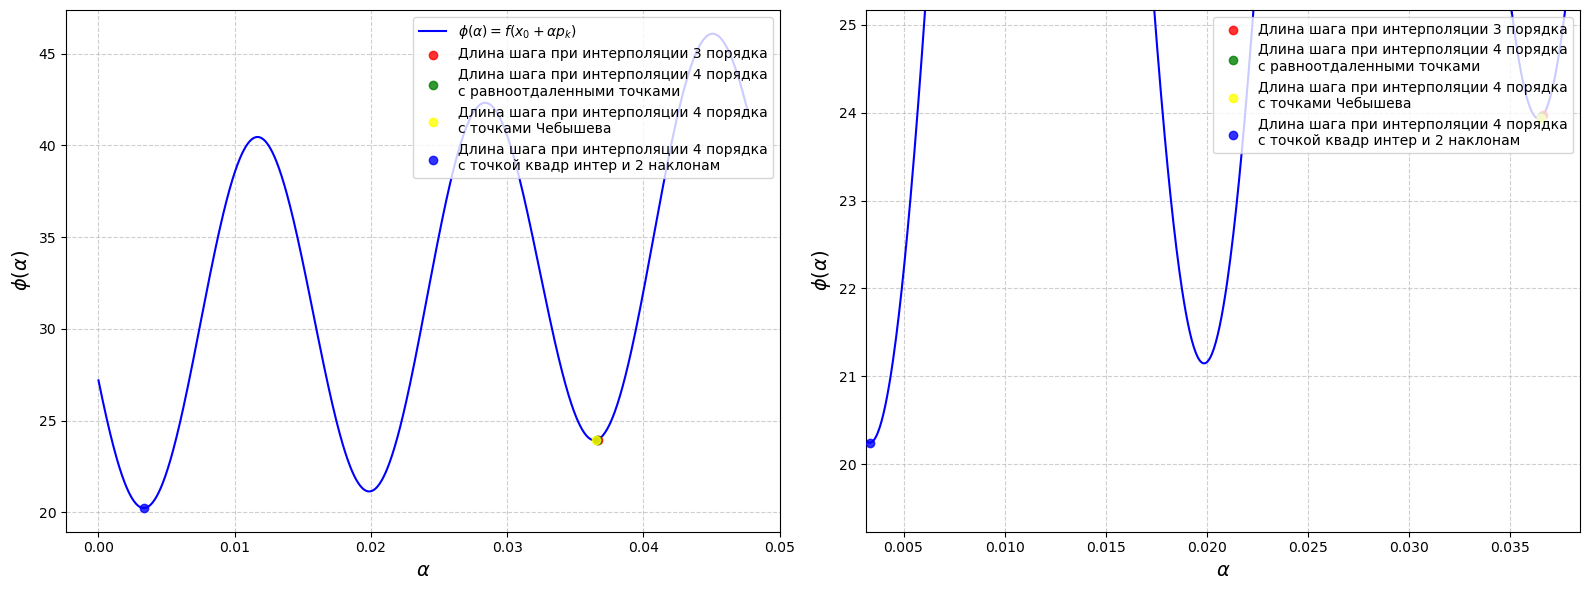

In [24]:
def rastrigin(x):
    A = 10 
    return A * 2 + (x[0]**2 - A * np.cos(2 * np.pi * x[0])) + (x[1]**2 - A * np.cos(2 * np.pi * x[1]))

def grad_rastrigin(x):
    A = 10 
    df_dx1 = 2 * x[0] + A * 2 * np.pi * np.sin(2 * np.pi * x[0])  
    df_dx2 = 2 * x[1] + A * 2 * np.pi * np.sin(2 * np.pi * x[1])  
    return np.array([df_dx1, df_dx2])

x0 = np.array([-0.2, 0.5])
eps = 1e-6
iteration = 100
ideal_solution = np.array([0.0, 0.0])

print(rastrigin(x0))
res_three, time_three = gradient_descent_three(rastrigin, grad_rastrigin, x0, ideal_solution, epsilon=eps, max_iterations=iteration)
alpha_1_three, result_three, fun_count_three, grad_count_three, iteration_three, trajectory_three = res_three


res_four_eq_sp_pts, time_four_eq_sp_pts  = gradient_descent_four(rastrigin, grad_rastrigin, x0, ideal_solution, method="equally_spaced_points", epsilon=eps, max_iterations=iteration)
alpha_1_four_eq_sp_pts, result_four_eq_sp_pts, fun_count_four_eq_sp_pts, grad_count_four_eq_sp_pts, iteration_four_eq_sp_pts = res_four_eq_sp_pts

res_four_cheb, time_four_cheb = gradient_descent_four(rastrigin, grad_rastrigin, x0, ideal_solution, method="chebyshev_roots", epsilon=eps, max_iterations=iteration)
alpha_1_four_cheb, result_four_cheb, fun_count_four_cheb, grad_count_four_cheb, iteration_four_cheb = res_four_cheb

res_inter_4_with_2, time_inter_4_with_2 = gradient_descent_four(rastrigin, grad_rastrigin, x0, ideal_solution, method="inter_4_with_2", epsilon=eps, max_iterations=iteration)
alpha_1_inter_4_with_2, result_inter_4_with_2, fun_count_inter_4_with_2, grad_count_inter_4_with_2, iteration_inter_4_with_2 = res_inter_4_with_2


methods = [
    ("Gradient \nDescent (Three)", fun_count_three, grad_count_three, iteration_three, result_three, rastrigin(result_three), time_three),
    ("Gradient \nDescent (Four\n(Равноудаленные))", fun_count_four_eq_sp_pts, grad_count_four_eq_sp_pts, iteration_four_eq_sp_pts, result_four_eq_sp_pts, rastrigin(result_four_eq_sp_pts),time_four_eq_sp_pts),
    ("Gradient \nDescent (Four\n(Чебышева))", fun_count_four_cheb, grad_count_four_cheb, iteration_four_cheb, result_four_cheb, rastrigin(result_four_cheb), time_four_cheb),
    ("G D (Four\n(Инт по 1 точке \nкв и 2 наклонам))", fun_count_inter_4_with_2, grad_count_inter_4_with_2, iteration_inter_4_with_2, result_inter_4_with_2, rastrigin(result_inter_4_with_2), time_inter_4_with_2)

]
table_data = []

for method_name, fun_count, grad_count, iterations, min_point, f_min, time_f in methods:
    table_data.append([
        method_name,   
        fun_count,      
        grad_count,    
        iterations,   
        min_point,    
        f_min,
        time_f
    ])

headers = [
    "Метод",
    "Кол-во вычиc\n функции",
    "Кол-во вычиc\n производной",
    "Кол-во \nитераций",
    "x_min",
    "f(x_min)",
    "Время"
]
floatfmt = [".14f"] * 6 + [".5f"]

print(tabulate(table_data, headers=headers, tablefmt="grid", floatfmt=floatfmt))

p_k = -grad_rastrigin(x0)
def phi(alpha):
    return rastrigin(x0 + alpha * p_k)

alpha_values = np.linspace(0, max(alpha_1_three, alpha_1_four_eq_sp_pts, alpha_1_four_cheb,alpha_1_inter_4_with_2) * 1.3, 1000)
phi_values = [phi(alpha) for alpha in alpha_values]
phi_values = np.array(phi_values)

alpha_points = [alpha_1_three, alpha_1_four_eq_sp_pts, alpha_1_four_cheb,alpha_1_inter_4_with_2]
phi_points = [phi(alpha) for alpha in alpha_points]
print(phi_points)
colors = ['red', 'green', 'yellow', "blue"]
labels = [
    'Длина шага при интерполяции 3 порядка', 
    'Длина шага при интерполяции 4 порядка\nс равноотдаленными точками', 
    'Длина шага при интерполяции 4 порядка\nс точками Чебышева',
    'Длина шага при интерполяции 4 порядка\nс точкой квадр интер и 2 наклонам'

]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

axes[0].plot(alpha_values, phi_values, label=r'$\phi(\alpha) = f(x_0 + \alpha p_k)$', color='blue')
for i, (alpha, phi_val) in enumerate(zip(alpha_points, phi_points)):
    axes[0].scatter(alpha, phi_val, color=colors[i], label=labels[i], zorder=5,alpha=0.8)
#axes[0].set_title('Общий график', fontsize=16)
axes[0].set_xlabel(r'$\alpha$', fontsize=14)
axes[0].set_ylabel(r'$\phi(\alpha)$', fontsize=14)
axes[0].legend(fontsize=10, loc='upper right')
axes[0].grid(True, linestyle='--', alpha=0.6)

zoom_x_min, zoom_x_max = min(alpha_points) * 0.95, max(alpha_points) * 1.05
zoom_y_min, zoom_y_max = min(phi_points) * 0.95, max(phi_points) *1.05

axes[1].plot(alpha_values, phi_values, color='blue')
for i, (alpha, phi_val) in enumerate(zip(alpha_points, phi_points)):
    if zoom_x_min <= alpha <= zoom_x_max:
        axes[1].scatter(alpha, phi_val, color=colors[i], label=labels[i], zorder=5, alpha=0.8)
axes[1].set_xlim(zoom_x_min, zoom_x_max)
axes[1].set_ylim(zoom_y_min, zoom_y_max)
#axes[1].set_title('Приближенный график', fontsize=16)
axes[1].set_xlabel(r'$\alpha$', fontsize=14)
axes[1].set_ylabel(r'$\phi(\alpha)$', fontsize=14)
axes[1].legend(fontsize=10, loc='upper right')
axes[1].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

